In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
import joblib

In [2]:
# Load the dataset
data = pd.read_csv('c:/Users/USER/Documents/Data Science Journy/StackingOptimization/driving_data.csv')

# Assume target variable is in between, adjust accordingly
target_column = 'Class'  # Replace with the actual target column name
X = data.drop(columns=[target_column])  # Features
y = data[target_column]   # Target (Driver ID)

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
# Feature Selection using Recursive Feature Elimination (RFE) with Random Forest
# Use Random Forest as the base model for RFE
base_model_for_rfe = RandomForestClassifier(n_estimators=100, random_state=42)

# Specify the number of features to select
n_features_to_select = 15  # You can adjust this based on your dataset

# Initialize RFE
rfe = RFE(estimator=base_model_for_rfe, n_features_to_select=n_features_to_select)

# Fit RFE on the training data
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Get the selected feature indices
selected_features = rfe.support_
print("Selected Features:", selected_features)

# Print the names of the selected features (if feature names are available)
feature_names = X.columns  # Use correct feature names
selected_feature_names = feature_names[selected_features]
print("Selected Feature Names:", selected_feature_names.tolist())

Selected Features: [False  True  True False  True False  True  True False False False  True
 False False  True False False False False  True False False  True False
 False False False False False False False  True False False  True  True
  True False False False False False False False False False False False
 False False False  True  True]
Selected Feature Names: ['Accelerator_Pedal_value', 'Throttle_position_signal', 'Intake_air_pressure', 'Absolute_throttle_position', 'Engine_soacking_time', 'Long_Term_Fuel_Trim_Bank1', 'Torque_of_friction', 'Engine_torque', 'Maximum_indicated_engine_torque', 'Activation_of_Air_compressor', 'Engine_coolant_temperature.1', 'Wheel_velocity_front_left-hand', 'Wheel_velocity_rear_right-hand', 'Time(s)', 'PathOrder']


In [4]:
# Define Random Forest classifier
random_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier on the selected features
random_classifier.fit(X_train_rfe, y_train)

# Make predictions on the test set
y_pred = random_classifier.predict(X_test_rfe)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy after RFE: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Save the model
#joblib.dump(random_classifier, 'driver_identification_model_rfe_rf.pkl')


Accuracy after RFE: 99.78%
Precision: 0.9978
Recall: 0.9978
F1 Score: 0.9978


In [5]:
# Cross-Validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(random_classifier, X_train_rfe, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%')
print(f'Cross-Validation Std: {cv_scores.std() * 100:.2f}%')

Cross-Validation Accuracy: 99.74%
Cross-Validation Std: 0.03%


In [6]:
# Check training vs. test accuracy
train_accuracy = accuracy_score(y_train, random_classifier.predict(X_train_rfe))
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 1.0000
Test Accuracy: 0.9978


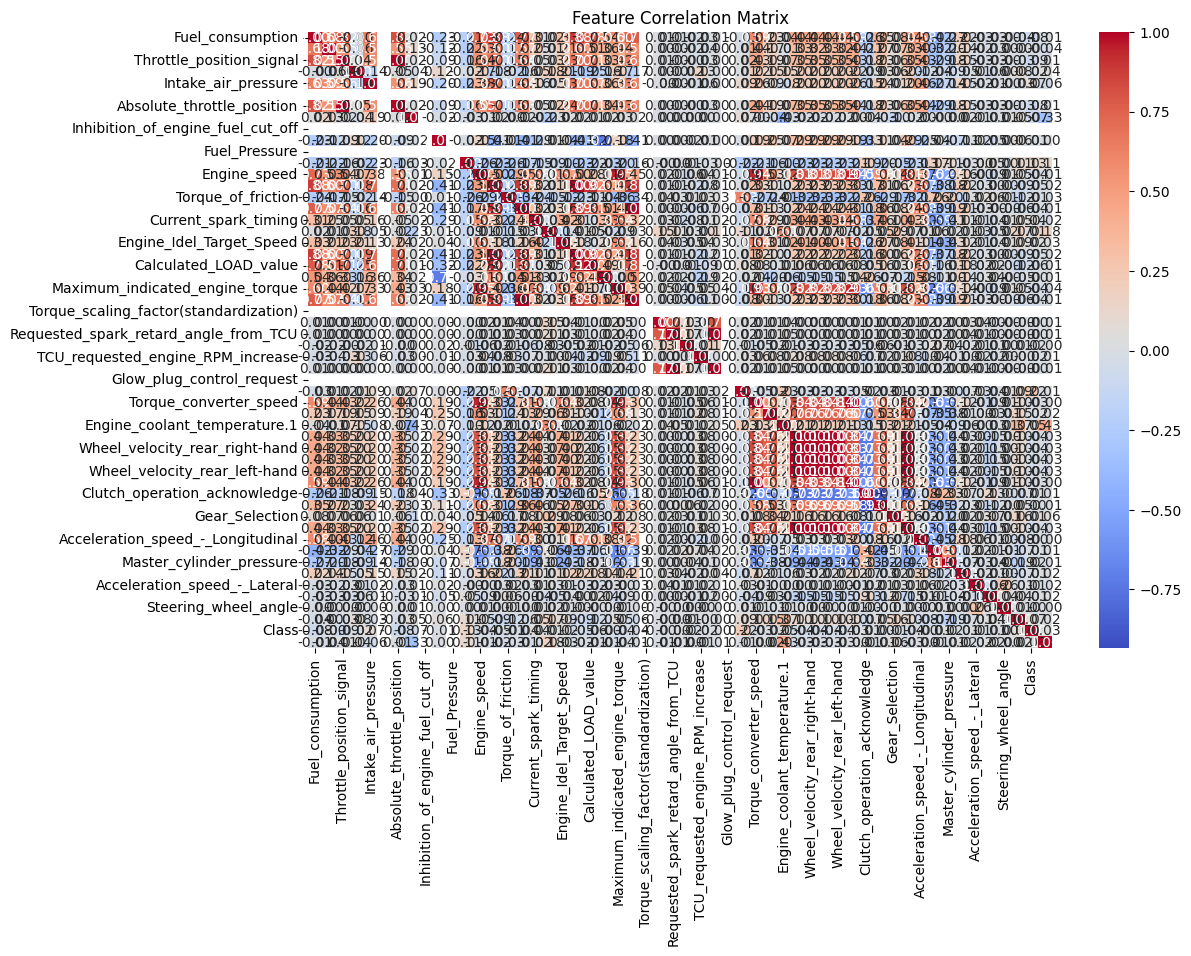

Class                                           1.000000
Activation_of_Air_compressor                    0.215960
Long_Term_Fuel_Trim_Bank1                       0.134810
Time(s)                                         0.071903
Intake_air_pressure                             0.069533
Engine_coolant_temperature.1                    0.046125
Current_spark_timing                            0.041463
PathOrder                                       0.026401
Master_cylinder_pressure                        0.022726
Engine_Idel_Target_Speed                        0.019031
TCU_requests_engine_torque_limit_(ETL)          0.018197
Acceleration_speed_-_Lateral                    0.013262
Engine_coolant_temperature                      0.011631
Clutch_operation_acknowledge                    0.010487
Gear_Selection                                  0.009648
Steering_wheel_angle                            0.002713
Converter_clutch                                0.000580
Accelerator_Pedal_value        

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Encode categorical features
data_encoded = data.copy()
for column in data_encoded.select_dtypes(include=['object']).columns:
	data_encoded[column] = label_encoder.fit_transform(data_encoded[column])

correlation_matrix = data_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

print(correlation_matrix[target_column].sort_values(ascending=False))


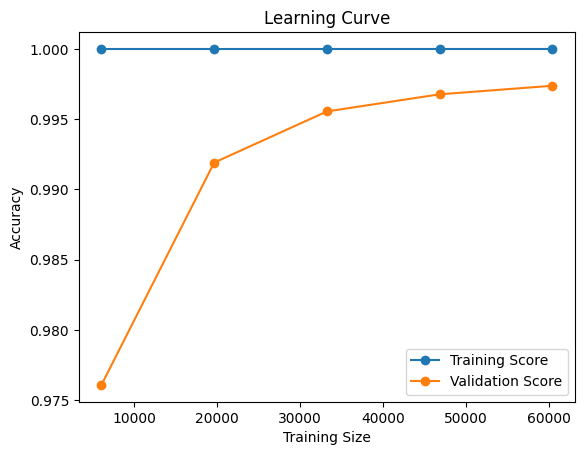

In [10]:
from sklearn.model_selection import learning_curve

# Plot Learning Curve
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='accuracy')
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training Score')
    plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label='Validation Score')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Learning Curve')
    plt.show()

plot_learning_curve(random_classifier, X_train_rfe, y_train)